In [1]:
import os
import scenic

### NuScenes Query
# from scenic.simulators.carla.nusc_query_api import NuscQueryAPI
# nusc = NuscQueryAPI(version='v1.0-trainval', \
#                     dataroot='/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data')

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/core/errors.py:160: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn('unable to install sys.excepthook to format Scenic backtraces')


In [2]:
import scenic
### Dependency Analysis
def cacheExprTreeNodes(attribute, nodeSet=None):
    """cache all the nodes of the input attribute's expression tree to the dictionary"""
    if nodeSet is None:
        nodeSet = set()
    nodeSet.add(attribute)
    if attribute._dependencies == ():
        return nodeSet
    for dep in attribute._dependencies:
        cacheExprTreeNodes(dep, nodeSet)
    return nodeSet

def cacheAttributes(scenario, attributeList):
    dictionary = {}
    dictionary['objAttributes_names'] = []
    dictionary['positionAttributes_names'] = []
    dictionary['headingAttributes_names'] = []
    
    # cache all object attributes
    for i in range(len(scenario.original_objects)):
        obj = scenario.original_objects[i]
        obj_name = 'obj'+str(i)
        dictionary[obj_name] = {}
        
        for attribute in attributeList:
            dictionary[obj_name][attribute] = {}
            dictionary[obj_name][attribute]['self'] = getattr(obj, attribute)
            dictionary[obj_name][attribute]['set'] = cacheExprTreeNodes(getattr(obj, attribute), None)
            dictionary[obj_name][attribute]['intermediate_variables_set'] = []
            dictionary[obj_name][attribute]['dependent_attribute_names'] = []
            dictionary[obj_name][attribute]['jointly_dependent_attribute_names'] = []
            dictionary[obj_name][attribute]['dependent_attributes_objs'] = set()
            dictionary[obj_name][attribute]['jointly_dependent_attributes_objs'] = set()
            dictionary['objAttributes_names'].append(obj_name+"_"+attribute)
            if attribute == 'position':
                dictionary['positionAttributes_names'].append(obj_name+"_"+attribute)
            if attribute == 'heading':
                dictionary['headingAttributes_names'].append(obj_name+"_"+attribute)
                
    return dictionary

def checkDependenceOnAnotherAttribute(intersection, attr1_name, attr2_name, dictionary):
    """ checks whether the two attr1 and attr2 are jointly dependent on an intermediate variable
    or is both dependent on another attribute. 
    Output:
    True, if attr1 and attr2 are "dependent" on another attribute, not intermediate variable
    False, attr1 and attr2 are both "jointly dependent" on an intermediate variable
    """
    [obj1_name, attr1] = attr1_name.split('_')
    attr1_obj = dictionary[obj1_name][attr1]['self']
    attr1_jointly_dep_attr_names = dictionary[obj1_name][attr1]['jointly_dependent_attribute_names']
    [obj2_name, attr2] = attr2_name.split('_')
    attr2_obj = dictionary[obj2_name][attr2]['self']
    attr2_jointly_dep_attr_names = dictionary[obj2_name][attr2]['jointly_dependent_attribute_names']
#     print("checkDependenceOnAnotherAttribute attr1_name: ", attr1_name)
#     print("checkDependenceOnAnotherAttribute attr2_name: ", attr2_name)
    original_intersection = intersection
    
    objAttributes_names = dictionary['objAttributes_names'] 
    for attr_name in objAttributes_names:
        if attr_name == attr1_name:
            continue
        elif attr_name == attr2_name:
            break
        else:
            [obj_name, attr] = attr_name.split('_')
            attr_obj = dictionary[obj_name][attr]['self']
            attr_depSet = dictionary[obj_name][attr]['dependent_attribute_names']
            
            if attr_obj in original_intersection and attr_name not in attr1_jointly_dep_attr_names \
                and attr_name not in attr2_jointly_dep_attr_names: 
#                 print("other attr_name in the intersection: ", attr_name)
                attr_cachedSet = dictionary[obj_name][attr]['set']
                original_intersection = original_intersection - attr_cachedSet
#                 print("len(original_intersection): ", len(original_intersection))
                if len(original_intersection) == 0:
#                     print("returns True")
                    # the intersection is another attribute
                    return True
    return False
        
def findAttribute(other_attr_obj, attr_dict, dictionary):
    for obj_attr in attr_dict['dependent_attribute_names']:
        [obj, attr] = obj_attr.split("_")
        if other_attr_obj is dictionary[obj][attr]['self']:
            return obj_attr
    return None

def checkIntermediateSetMembership(attr_obj, attrIntermediateList):
    for intermediateSet in attrIntermediateList:
        if attr_obj in intermediateSet:
            return True
    return False

def analysis(objAttributes_names, dictionary):
    for i in range(len(objAttributes_names)):
        for j in range(len(objAttributes_names)):
            if i < j:
                attr1_name = objAttributes_names[i]
                attr2_name = objAttributes_names[j]
                [obj_name1, attr1] = attr1_name.split('_')
                [obj_name2, attr2] = attr2_name.split('_')
        
                attribute1 = dictionary[obj_name1][attr1]
                attribute2 = dictionary[obj_name2][attr2]
                attr1_obj = attribute1['self']
                attr2_obj = attribute2['self']
                
                set1 = attribute1['set']
                set2 = attribute2['set']
                intersection = set1.intersection(set2)
                
                if attr1_obj in intersection and attr1_obj not in attribute2['dependent_attributes_objs']:
                    # attr2_obj is dependent on attr1_obj
                    attribute2['dependent_attribute_names'].append(attr1_name)
                    attribute2['dependent_attributes_objs'].add(attr1_obj)
                elif attr2_obj in intersection and attr2_obj not in attribute1['dependent_attributes_objs']:
                    # jointly_dependent case (e.g. depedendencyAnalysisTest4.scenic)
                    if attr2_name not in attribute1['jointly_dependent_attribute_names']:
                        attribute1['jointly_dependent_attribute_names'].append(attr2_name)
                        attribute1['jointly_dependent_attributes_objs'].add(attr2_obj)     
                        attribute1['intermediate_variables_set'].append(intersection)

                    if attr1_name not in attribute2['jointly_dependent_attribute_names']:
                        attribute2['jointly_dependent_attribute_names'].append(attr1_name)
                        attribute2['jointly_dependent_attributes_objs'].add(attr1_obj)
                        attribute2['intermediate_variables_set'].append(intersection)
                        
                elif len(intersection) > 0 \
                    and attr1_obj not in intersection and attr2_obj not in intersection \
                    and not checkDependenceOnAnotherAttribute(intersection, attr1_name, attr2_name, dictionary):
                    # the two attributes are jointly dependent (i.e. share intermediate variable(s))
                    if attr2_name not in attribute1['jointly_dependent_attribute_names']:
                        attribute1['jointly_dependent_attribute_names'].append(attr2_name)
                        attribute1['jointly_dependent_attributes_objs'].add(attr2_obj)     
                        attribute1['intermediate_variables_set'].append(intersection)
                    
                    if attr1_name not in attribute2['jointly_dependent_attribute_names']:
                        attribute2['jointly_dependent_attribute_names'].append(attr1_name)
                        attribute2['jointly_dependent_attributes_objs'].add(attr1_obj)
                        attribute2['intermediate_variables_set'].append(intersection)

                else:
                    pass
    return dictionary
    
def dependencyAnalysis(scenario, attributeList):
    dictionary = cacheAttributes(scenario, attributeList)
    dictionary['numberOfObjects'] = len(scenario.original_objects)
    objAttributes_names = dictionary['objAttributes_names']
    dictionary = analysis(objAttributes_names, dictionary)
    return dictionary

def sortDependency(dictionary, scenario, monolithic_translation=False):
    output = []
    covered_attributes = []
    
    if not monolithic_translation:
        for elem in dictionary['objAttributes_names']:
            if elem in covered_attributes:
                continue
            covered_attributes.append(elem)
            [obj_name, attr_name] = elem.split("_")
            joint_dep_set = dictionary[obj_name][attr_name]['jointly_dependent_attribute_names']
            if len(joint_dep_set) > 0:
                jointly_dependent_list = [elem]

                for j in joint_dep_set:
                    [j_obj_name, j_attr] = j.split("_")
                    if j not in covered_attributes:
                        jointly_dependent_list.append(j)
                        covered_attributes.append(j)
                output.append(jointly_dependent_list)
            else:
                output.append([elem])
    else:
        output = [(dictionary['objAttributes_names'])]
    return output

In [3]:
# ## Test Dependency Analysis

# attributeList = ['position', 'heading']
# d = dependencyAnalysis(scenario, attributeList)
# print(sortDependency(d, scenario))

In [4]:
### SMT Translation Pipeline

from scenic.core.regions import SectorRegion, CircularRegion
from scenic.core.vectors import OrientedVector, Vector
from scenic.core.distributions import *
from scenic.domains.driving.roads import Network
from scenic.core.regions import PointInRegionDistribution
from scenic.core.type_support import TypecheckedDistribution
from scenic.core.geometry import normalizeAngle
import subprocess
import itertools
import numpy as np
import os

def resetConditionedVar(obj):
    obj._conditioned = obj
    if (obj._dependencies is None):
        return None
    for dep in obj._dependencies:
        resetConditionedVar(dep)
    return None

def unconditionAllAttributes(scenario):
    for obj in scenario.objects:
        resetConditionedVar(obj.position)
        resetConditionedVar(obj.heading)
        
def extractLabelAttribute(label, obj_index, attribute_name, objType, dataType, correspondence, egoObjIndex):
    # Extract specific attribute from a label generated from a scenic program
    
#     print("extractLabelAttribute()")
#     print("label[objType]: ", label[objType])
#     print("correspondence: ", correspondence)
#     print("correspondence[obj_index]: ", correspondence[obj_index])
#     print("attribute_name: ", attribute_name)
#     print("obj_index: ", obj_index)
#     print("egoObjIndex: ", egoObjIndex)
    output = None
    if obj_index != egoObjIndex:
        if obj_index > egoObjIndex:
            output = label[objType][correspondence[obj_index-1]][attribute_name]
    else:
        output = label['EgoCar'][attribute_name]

    assert(output is not None)
    if attribute_name == 'position':
        return Vector(output[0], output[1])
    if dataType == 'nuScenes':
        output = normalizeAngle(math.radians(output-90)) #90 deg to reorient to Scenic's global coordinate system
    return output
        
def initializeSMTFile(smt_file_path):
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')
    
def resetDictionary(cached_variables, smt_file_path):
    regionAroundEgo = cached_variables['regionAroundEgo']
    cached_variables.clear()
    cached_variables['variables'] = []
    cached_variables['regionAroundEgo'] = regionAroundEgo
    cached_variables['regionAroundEgo_polygon'] = regionAroundEgo.polygon
    cached_variables['smt_file_path'] = smt_file_path

def translateAttributeExpressionTree(attribute_name, attr_obj, attr_label, cached_variables, \
                                   dictionary, errorBound, debug=False):
    
    x_error_margin = str(errorBound['x'])
    y_error_margin = str(errorBound['y'])
    heading_error_margin = errorBound['heading']
    
    ## TODO: add error bound range to attributes
    smt_file_path = cached_variables['smt_file_path']
    obj_name, attr_type = attribute_name.split("_")

    # Encode the given attribute's expression tree
    smt_var = attr_obj.encodeToSMT(smt_file_path, cached_variables, debug = debug)
    if smt_var is None:
        return False
    
    if attr_type == 'position':
        assert(isinstance(attr_label, Vector))
        x, y = smt_var
        (x_label, y_label) = (str(attr_label.x), str(attr_label.y))
        x_cond1 = smt_lessThanEq(smt_subtract(x_label, x_error_margin), x)
        x_cond2 = smt_lessThanEq(x, smt_add(x_label, x_error_margin))
        x_cond = smt_and(x_cond1, x_cond2)
        
        y_cond1 = smt_lessThanEq(smt_subtract(y_label, y_error_margin), y)
        y_cond2 = smt_lessThanEq(y, smt_add(y_label, y_error_margin))
        y_cond = smt_and(y_cond1, y_cond2)
        
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_and(x_cond, y_cond)))
    else:
        heading_label = str(attr_label)
        
        # normalize heading
        norm_var = findVariableName(smt_file_path, cached_variables, 'normalized', debug=debug)
        normalize1 = smt_assert("equal", norm_var, smt_ite(smt_lessThanEq("3.1416", smt_var), \
                                                    smt_subtract(smt_var,"6.2832"), \
                                                    smt_ite(smt_lessThanEq(smt_var, "-3.1416"), \
                                                    smt_add(smt_var,"6.2832"), smt_var)))
        writeSMTtoFile(smt_file_path, normalize1)
        
        # check heading within [-pi, pi] interval
        heading_cond1 = smt_lessThanEq(smt_subtract(heading_label, str(heading_error_margin)), norm_var)
        heading_cond2 = smt_lessThanEq(norm_var, smt_add(heading_label, str(heading_error_margin)))
        heading1 = smt_and(heading_cond1, heading_cond2)
        
        # check heading at wrap around case
        if attr_label > 0:
            smt_var2 = smt_add(smt_subtract(str(3.1416), str(heading_label)), smt_subtract(norm_var, str(-3.1416)))
        else:
            smt_var2 = smt_add(smt_subtract(str(heading_label), str(-3.1416)), smt_subtract(str(3.1416), norm_var))
        heading_cond1 = smt_lessThanEq(str(-heading_error_margin), smt_var2)
        heading_cond2 = smt_lessThanEq(smt_var2, str(heading_error_margin))
        heading2 = smt_and(heading_cond1, heading_cond2)
        
        heading = smt_or(heading1, heading2)            
        writeSMTtoFile(smt_file_path, smt_assert(None, heading))
#         writeSMTtoFile(smt_file_path, smt_assert(None, smt_equal(str(attr_label), smt_var)))
    return True
        
def findObjType(obj):
    if "Car" in str(obj) or "Truck" in str(obj) or "Motorcycle" in str(obj) or "Bicycle" in str(obj):
        return "Vehicles"
    elif "Pedestrian" in str(obj):
        return "Pedestrians"
    elif "Cone" in str(obj) or "Trash" in str(obj):
        return "Objects"
    else:
        raise NotImplementedError
    return None

def conditionAttributes(jointlyDependentAttributeList, dictionary, scenario, dataType, correspondence, \
                        egoObjIndex, label):
    for attribute_name in jointlyDependentAttributeList:
        obj_name, attr_name = attribute_name.split("_")
        obj_index = int(obj_name.split("obj")[1])
        objType = findObjType(scenario.original_objects[obj_index])
        attr_label = extractLabelAttribute(label, obj_index, attr_name, objType, dataType, correspondence, \
                                              egoObjIndex)
        attr_obj = dictionary[obj_name][attr_name]['self']
#         print("conditionAttributes attribute: ", attribute_name)
#         print("conditionAttributes attr_label: ", attr_label)
        if isinstance(attr_label, float) or isinstance(attr_label, int):
            attr_obj.conditionTo(Constant(attr_label))
        elif isinstance(attr_obj, PointInRegionDistribution):
            attr_obj.conditionTo(attr_label)
            if isinstance(attr_obj.region, TypecheckedDistribution): 
                attr_obj.region.dist.conditionTo(attr_label)
            else:
                attr_obj.region.conditionTo(attr_label)
        else:
            attr_obj.conditionTo(attr_label)

def validateLabelElement(scenario, label, cached_variables, jointlyDependentAttributeList, dictionary, \
                         correspondence, egoObjIndex, dataType, errorBound, debug=False, falseTesting=False,\
                        monolithic_translation=False):
    
    count = 0
    ## translate jointly dependent attribute expression trees
    for attribute_name in jointlyDependentAttributeList:

        obj_name, attr_name = attribute_name.split("_")
        obj_index = int(obj_name.split("obj")[1])
        objType = findObjType(scenario.original_objects[obj_index])
        attr_label = extractLabelAttribute(label, obj_index, attr_name, objType, dataType, correspondence,\
                                          egoObjIndex)
        print("validateLabelElement() attribute_name: ", attribute_name)
        print("attr_label: ", attr_label)
        print("correspondence: ", correspondence)
        attr_obj = dictionary[obj_name][attr_name]['self']
        translated = translateAttributeExpressionTree(attribute_name, attr_obj, attr_label, cached_variables, \
                                          dictionary, errorBound, debug)
        if not translated:
            print("TRANSLATION FAILED: NONE RETURNED")
            return False
#         print("validateLabelElement encoding done for validateLabelElement: ", attribute_name)
#         if monolithic_translation:
#             print("validLabelElement: Monolithic translation case -- condition attribute: ",attribute_name)
#             conditionAttributes([attribute_name], dictionary, scenario, dataType, correspondence, \
#                         egoObjIndex, label)
    
    smt_file_path = cached_variables['smt_file_path']
    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    if subprocess.call("./run_smt_encoding.sh") == 1:
        return True
        
    return False

def createCorrespondence(correspondence, objType, objTypeOrder, objTypeCorrespondence):
    index = 0
    correspond_copy = correspondence.copy()
    for i in range(len(objTypeOrder)):
        if objTypeOrder[i] == objType:
            correspond_copy[i] = objTypeCorrespondence[index]
            index += 1
            if index == len(objTypeCorrespondence):
                break
    return correspond_copy
    

def findEgoObjIndex(scenario):
    for i in range(len(scenario.original_objects)):
        if scenario.original_objects[i] is scenario.egoObject:
            return i
    return None


In [5]:
def refinePermutation(permutation_list, num_elem):
    refined_list = set()
    for perm in permutation_list:
        refined_list.add(tuple(list(perm)[:num_elem]))
    output = list(refined_list)
    output.sort()
    return output

def generateObjectMatchingCorrespondenceSet(scenario, label):
    objTypeOrder = []
    objTypeDict = {}
    
    # Count the number of objType in the Scenic program and the label
    for obj in scenario.original_objects:
        if obj is not scenario.egoObject:
            objType = findObjType(obj)
            objTypeOrder.append(objType)
            
            if objType not in objTypeDict.keys():
                objTypeDict[objType] = {}
                objTypeDict[objType]['label_count'] = len(label[objType])
                objTypeDict[objType]['scenic_count'] = 1
            else:
                objTypeDict[objType]['scenic_count'] += 1
    
    print("objTypeOrder: ", objTypeOrder)
    
    # 
    total_permutation_number = 1
    for objType in objTypeDict.keys():
        label_count = objTypeDict[objType]['label_count']
        scenic_count= objTypeDict[objType]['scenic_count']
        assert(label_count >= scenic_count)
        
        index_list = [i for i in range(label_count)]
        permutation_list = list(itertools.permutations(index_list))
        objTypeDict[objType]['correspondence'] = refinePermutation(permutation_list, scenic_count)
        total_permutation_number *= int(math.factorial(label_count) / math.factorial(label_count - scenic_count))
    
    print("total_permutation_number: ", total_permutation_number)
    for objType in objTypeDict.keys():
        print("objType: ", objType)
        print("objType scenic_count: ", objTypeDict[objType]['scenic_count'])
        print("objType label_count: ", objTypeDict[objType]['label_count'])
        print("objType Correspondence: ", objTypeDict[objType]['correspondence'])
        print("len(correspondence): ", len(objTypeDict[objType]['correspondence']))
#     print("objTypeDict['Vehicles']['scenic_count']: ", objTypeDict['Vehicles']['scenic_count'])
#     print("objTypeDict['Vehicles']['label_count']: ", objTypeDict['Vehicles']['label_count'])
#     print("objTypeDict['Vehicles']['correspondence']: ", objTypeDict['Vehicles']['correspondence'])
#     print("len(objTypeDict['Vehicles']['correspondence']): ", len(objTypeDict['Vehicles']['correspondence']))
#     print("objTypeDict['Pedestrians']['scenic_count']", objTypeDict['Pedestrians']['scenic_count'])
#     print("objTypeDict['Pedestrians']['label_count']", objTypeDict['Pedestrians']['label_count'])
#     print("objTypeDict['Pedestrians']['correspondence']", objTypeDict['Pedestrians']['correspondence'])
#     print("objTypeDict['Objects']['count']", objTypeDict['Objects']['count'])
#     print("objTypeDict['Objects']['correspondence']", objTypeDict['Objects']['correspondence'])
    
    # sort the types by the number of counts
    types = list(objTypeDict.keys())
    counts = [len(objTypeDict[objType]['correspondence']) for objType in types]
    sorted_types = []
    sorted_types_nums = []
    
    for i in range(len(types)):
        elem = max(counts)
        index = counts.index(max(counts))
        sorted_types.append(types[index])
        sorted_types_nums.append(elem)
        del types[index]
        del counts[index]
    
#     print("sorted_types: ", sorted_types)
#     print("sorted_types_nums: ", sorted_types_nums)
    
    if len(objTypeOrder)==0:
        return [(0,)]
    
    # compute the number of identical elements to insert per objType
    num_identicals = []
    for i in range(len(sorted_types)):
        if i == len(sorted_types)-1:
            num_identicals.append(1)
        else:
            num_identicals.append(np.prod(sorted_types_nums[i+1:]))
    print("num_identicals: ", num_identicals)
    
    # create combinations of correspondences in the order of objTypeOrder
    print("total_permutation_number: ", total_permutation_number)
    correspondenceList = [[0]*len(objTypeOrder) for i in range(total_permutation_number)]
#     print("correspondenceList: ", correspondenceList)

    # Handling first objType
    objType = sorted_types[0]
    for j in range(len(objTypeDict[objType]['correspondence'])):
        correspondenceToEdit = correspondenceList[index]
#         print("correspondenceToEdit: ", correspondenceToEdit)
        objTypeCorrespondence = objTypeDict[objType]['correspondence'][j]
#         print("objTypeCorrespondence: ", objTypeCorrespondence)
        correspondence = createCorrespondence(correspondenceToEdit, objType, objTypeOrder, \
                                              objTypeCorrespondence)
#         print("correspondence: ", correspondence)

        for k in range(num_identicals[0]):
            correspondenceList[index] = correspondence
            index += 1
#     print("correspondenceList: ", correspondenceList)
#     print("len(correspondenceList): ", len(correspondenceList))
#     print("correspondenceList is Valid: ", len(correspondenceList)/num_identicals[0]==\
#           len(set([tuple(elem) for elem in correspondenceList])))
    
    # Handle the rest of objType 
    for i in range(1,len(sorted_types)):
    # for each remaining object
        index = 0
        objType = sorted_types[i]
#         print("processing objType: ", objType)
        for j in range(len(objTypeDict[sorted_types[0]]['correspondence'])): 
        # loop for the number of first objType's correspondence
            for k in range(len(objTypeDict[objType]['correspondence'])):
            # loop for the number of distinct correspondences of remaining per obj
                correspondenceToEdit = correspondenceList[index]
#                 print("correspondenceToEdit: ", correspondenceToEdit)
                objTypeCorrespondence = objTypeDict[objType]['correspondence'][k]
#                 print("objTypeCorrespondence: ", objTypeCorrespondence)
                correspondence = createCorrespondence(correspondenceToEdit, objType, \
                                objTypeOrder, objTypeCorrespondence)
#                 print("correspondence: ", correspondence)
                for l in range(num_identicals[i]):
                    correspondenceList[index] = correspondence
                    index += 1
#                     print("index: ", index)
                
#                 print("kth loop completed: ", k)
#             print("jth full loop completed: ", j)

#     print("correspondenceList: ", correspondenceList)
    
    return correspondenceList


In [6]:
# import scenic
# scenic_script = "./examples/carla/ICCV_Scenic_Experiments/8_agent_scenario.scenic"
# scenario = scenic.scenarioFromFile(scenic_script)
# x = generateObjectMatchingCorrespondenceSet(scenario)
# print("finalOutput: ", x)
# print(len(x))
# print(len(set([tuple(elem) for elem in x])))

# label = {}
# label['Vehicles'] = [0,1,2]
# label['Pedestrians'] = [0,1,2,3]
# # scenic_script_path = "./examples/carla/ICCV_Human_Experiments/experiment1.scenic"
# # scenario = scenic.scenarioFromFile(scenic_script_path)
# l = generateObjectMatchingCorrespondenceSet(scenario, label)
# print(len(l))
# print(l)

In [7]:
x = 'strin_0g'
print('1' in x)

False


In [8]:
### Object Matching
import math

def conditionAllAttributes(scenario, dictionary, label, attributeList, correspondence, egoObjIndex, dataType):
    for obj_index in range(len(scenario.original_objects)):
        obj = scenario.original_objects[obj_index]
        for attribute_name in attributeList:
            objType = findObjType(obj)
            attr_label = extractLabelAttribute(label, obj_index, attribute_name, objType, \
                                               dataType, correspondence, egoObjIndex)
            if isinstance(attr_label, (float, int)):
                attr_label = Constant(attr_label)
            obj_attr = getattr(obj, attribute_name)
            obj_attr.conditionTo(attr_label)

def satisfyHardConstraints(scenario, dictionary, label, attributeList, correspondence, egoObjIndex, dataType):
    unconditionAllAttributes(scenario)
    conditionAllAttributes(scenario, dictionary, label, attributeList, correspondence, egoObjIndex, dataType)
    return scenario.checkRequirements()

def scenarioObjClassCount(scenario):
    # check whether the number of objects match per class
    objClassCountDict = {}
    for obj in scenario.original_objects:
        objType = findObjType(obj)
        if obj is not scenario.egoObject:
            if objType not in objClassCountDict.keys():
                objClassCountDict[objType] = {}
                objClassCountDict[objType]['count'] = 1
            else:
                objClassCountDict[objType]['count'] += 1
        else:
            objClassCountDict['EgoCar'] = {}
            objClassCountDict['EgoCar']['count'] = 1
    return objClassCountDict

def checkLabelValidity(label, objClassCountDict):
    for objType in objClassCountDict.keys():
        if objType == 'EgoCar':
            continue
        if len(label[objType]) < objClassCountDict[objType]['count']:
            print("INVALID LABEL -- scenario vs label objects mismatch")
            print("Issue object type: ", objType)
            print("len(label[objType]): ", len(label[objType]))
            print("scenaro objectType's obj number: ", objClassCountDict[objType]['count'])
            return False
    return True

def queryLabelSetup(scenario, smt_file_path='./test_smt_encoding.smt2', attributeList = ['position', 'heading'],\
                   dataType='carla', monolithic_translation=False):
    # Uncondition previously conditioned dependency objects
    unconditionAllAttributes(scenario)
    
    # setup basic info
    cached_variables = {}
    cached_variables['smt_file_path'] = smt_file_path
    cached_variables['variables'] = []
    egoObjIndex = findEgoObjIndex(scenario)
    objClassCountDict = scenarioObjClassCount(scenario)
    
    # Sort Attribute Dependency 
    dictionary = dependencyAnalysis(scenario, attributeList)
    sortedDependencyList = sortDependency(dictionary, scenario, monolithic_translation)
    
    outputDict = {}
    outputDict['cached_variables'] = cached_variables
    outputDict['sortedDependencyList'] = sortedDependencyList
    outputDict['egoObjIndex'] = egoObjIndex
    outputDict['dictionary'] = dictionary
    outputDict['objClassCountDict'] = objClassCountDict
    outputDict['attributeList'] = attributeList
    return outputDict

def egoObjInList(jointlyDependentAttributeList, egoObjIndex):
    for attr in jointlyDependentAttributeList:
        if str(egoObjIndex) in attr:
            return True
    return False
    
def queryLabel(scenario, label, outputDict, errorBound, ego_visibleDistance = 30, ego_viewAngle = 135,\
               dataType='carla', smt_file_path='./test_smt_encoding.smt2', \
               debug=False, monolithic_translation = False, scenic_testing=False):
    
    objClassCountDict = outputDict['objClassCountDict']
    print("objClassCountDict: ", objClassCountDict)
    if not checkLabelValidity(label, objClassCountDict):
        # number of objects do not match per class ==> reject the label
        print("INVALD LABEL! Obj Count does not match")
        return False
    
    # Compute All Correspondence
    allObjCorrespondence = generateObjectMatchingCorrespondenceSet(scenario, label)
    print("allObjCorrespondence: ", allObjCorrespondence)
    
    # Unpack variables
    cached_variables = outputDict['cached_variables']
    sortedDependencyList = outputDict['sortedDependencyList']
    egoObjIndex = outputDict['egoObjIndex']
    print("egoObjIndex: ", egoObjIndex)
    dictionary = outputDict['dictionary']
    attributeList = outputDict['attributeList']
    
    # Create Ego visible region
    (ego_x, ego_y) = label['EgoCar']['position']
    label_ego_pos = extractLabelAttribute(label, egoObjIndex, 'position', 'EgoCar', \
                                                  dataType, None, egoObjIndex)
#     label_ego_heading = extractLabelAttribute(label, egoObjIndex, 'heading', 'EgoCar', \
#                                                   dataType, None, egoObjIndex)
#     regionAroundEgo = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
#                                     math.radians(ego_viewAngle))
    regionAroundEgo = CircularRegion(label_ego_pos, ego_visibleDistance)
    cached_variables['regionAroundEgo'] = regionAroundEgo
    cached_variables['regionAroundEgo_polygon'] = regionAroundEgo.polygon
    
    # Uncondition previously conditioned dependency objects
    unconditionAllAttributes(scenario)
    
#     print("begin query")
    for correspondence in allObjCorrespondence:    
        failed, egoInList = False, False
#         print("queryLabel correspondence: ", correspondence)
        for jointlyDependentAttributeList in sortedDependencyList:
            egoInList = egoObjInList(jointlyDependentAttributeList, egoObjIndex)
            # Initialize smt file, if exists
            initializeSMTFile(smt_file_path)
            print(".........................validating : ", str(jointlyDependentAttributeList)+".......................")
            if validateLabelElement(scenario, label, cached_variables, jointlyDependentAttributeList, dictionary, \
                                            correspondence, egoObjIndex, dataType, errorBound, debug=debug, \
                                            monolithic_translation=monolithic_translation):
                print(".........................VALID ATTRIBUTE(S): ", str(jointlyDependentAttributeList)+".......................")
                conditionAttributes(jointlyDependentAttributeList, dictionary, scenario, dataType, \
                                    correspondence, egoObjIndex, label)
                resetDictionary(cached_variables, smt_file_path)
            else: # condition attributes in jointlyDependentAttributeList
                print("INVALD LABEL -- NON-VALID ATTRIBUTES: ", jointlyDependentAttributeList)
                failed = True
                unconditionAllAttributes(scenario)
                resetDictionary(cached_variables, smt_file_path)
                if egoInList:
                    print("ego object was in the list")
                    return False
                break
        
        ## Check Hard Constraint Satisfaction
        hardConstraintValid = satisfyHardConstraints(scenario, dictionary, label, attributeList, \
                                                 correspondence, egoObjIndex, dataType)
        
        if failed and scenic_testing:
            return False
        
        if not failed and hardConstraintValid:
            return True
        else:
            if not failed and not hardConstraintValid:
                print("INVALID LABELS -- HARD CONSTRAINT NOT SATISFIED")
            if scenic_testing:
                # the first correspondence is valid
                return False
            failed = False
            unconditionAllAttributes(scenario)
            resetDictionary(cached_variables, smt_file_path)

    return False

def convertScenicLabel(scenic_label):
    label = {}
    label['EgoCar'] = {}
    ego_pos = scenic_label.egoObject.position
    label['EgoCar']['position'] = (ego_pos[0], ego_pos[1])
    label['EgoCar']['heading'] = scenic_label.egoObject.heading
    label['Vehicles'] = []
    label['Pedestrians'] = []
    label['Objects'] = []
    for obj in scenic_label.objects:
        if obj is not scenic_label.egoObject:
            objType = findObjType(obj)
            objDict = {}
            objPos = obj.position
            objDict['position'] = (objPos[0], objPos[1])
            objDict['heading'] = obj.heading
            label[objType].append(objDict)
    return label

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


sortedDependencyList:  [['obj0_position', 'obj1_position'], ['obj0_heading'], ['obj1_heading']]


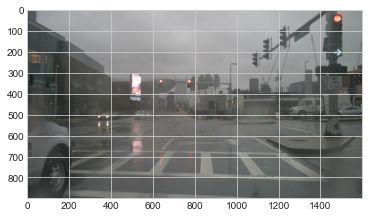

NameError: name 'nusc' is not defined

In [9]:
import matplotlib.image as mpimg

def nuScenesExperiment(scenario, dataset_directory_path):
    outputDict = queryLabelSetup(scenario,  smt_file_path='./test_smt_encoding.smt2', \
                                 attributeList = ['position', 'heading'],dataType = 'nuScenes')
    errorBound = {}
    errorBound['x'] = 0.25 # meters == radius of the error margin ball around x
    errorBound['y'] = 0.25 # meters == radius of the error margin ball around y
    errorBound['heading'] = 0.0872 # radians = 5 degrees
    print("sortedDependencyList: ", outputDict['sortedDependencyList'])
    
    filenames = [file for file in os.listdir(dataset_directory_path) if file.endswith('.jpg')]
    count = 0
    valid_files = []
    invalid_files = []
    for file in filenames:
        img = mpimg.imread(os.path.join(dataset_directory_path, file))
        plt.imshow(img)
        plt.show()
        unconditionAllAttributes(scenario)
        label = nusc.get_img_data(file)
        print("label: ", label)
        if not queryLabel(scenario, label, outputDict, errorBound, ego_visibleDistance = 50, \
                          dataType='nuScenes', debug=False):
            print("LABEL NOT VALID: ", file)
            invalid_files.append(file)
        else:
            print("LABEL VALID: ", file)
            valid_files.append(file)
    return valid_files, invalid_files

directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_results'
subject1 = 'experiment_result_JayShenoy'
subject2 = 'experiment_result_TaeSung'
subject3 = 'experiment_result_Xiangyu'
scenario_list = ['scenario1','scenario2','scenario3','scenario4','scenario5']
dataset_directory_path = os.path.join(directory, 'data')
scenic_script_path = "./examples/carla/ICCV_Human_Experiments/experiment1.scenic"
scenario = scenic.scenarioFromFile(scenic_script_path)
valid_files, invalid_files = nuScenesExperiment(scenario, dataset_directory_path)

In [ ]:
print(len(valid_files))
print(len(invalid_files))
invalids = invalid_files.copy()
valids = valid_files.copy()

In [ ]:
import shutil
for file in invalid_files:
    src_path = os.path.join(dataset_directory_path, file)
    dst_path = os.path.join('/Users/edwardkim/Desktop/Issue_Labels', file)
    shutil.copy(src_path, dst_path)

In [ ]:
from scenic.core.geometry import normalizeAngle
from scenic.core.vectors import Vector
from nuscenes.map_expansion.map_api import NuScenesMap

dataroot = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data'
map_api = NuScenesMap(dataroot=dataroot, map_name='boston-seaport')

def get_traffic_flow(point):
    lane_token = map_api.record_on_point(point.x, point.y, 'lane')

    if lane_token == '':
        return 0

    lane_rec = map_api.get('lane', lane_token)

    from_edge = map_api.get('line', lane_rec['from_edge_line_token'])
    to_edge = map_api.get('line', lane_rec['to_edge_line_token'])

    from_nodes = [map_api.get('node', t) for t in from_edge['node_tokens']]
    from_nodes = [np.array([n['x'], n['y']]) for n in from_nodes]
    to_nodes = [map_api.get('node', t) for t in to_edge['node_tokens']]
    to_nodes = [np.array([n['x'], n['y']]) for n in to_nodes]

    # Compute traffic flow vector using midpoints of edges
    from_mid = (from_nodes[0] + from_nodes[1]) / 2
    to_mid = (to_nodes[0] + to_nodes[1]) / 2
    traffic_flow_vec = to_mid - from_mid

    heading = np.arctan2(traffic_flow_vec[1], traffic_flow_vec[0])
    output = normalizeAngle(heading - (np.pi /2))
    return output

point = Vector(1736.711336168919, 1236.0473585795185)
print(math.degrees(get_traffic_flow(point)))

In [13]:
import scenic
import time

def runExperiment(scenario, numTest, monolithic_translation=False):
    outputDict = queryLabelSetup(scenario,  smt_file_path='./test_smt_encoding.smt2', \
                                 attributeList = ['position', 'heading'],dataType = 'carla',\
                                 monolithic_translation=monolithic_translation)
    errorBound = {}
    errorBound['x'] = 0.25 # meters == radius of the error margin ball around x
    errorBound['y'] = 0.25 # meters == radius of the error margin ball around y
    errorBound['heading'] = 0.17453292 # radians = 10 degrees
#     print("sortedDependencyList: ", outputDict['sortedDependencyList'])
    
    generatedScenicLabels = []
    time_measurements = []
    
    count = 0
    for i in range(numTest):
        count+=1 
        unconditionAllAttributes(scenario)
        print(".......... sampling a new scene from the scenic program ..........")
        scenic_label, _ = scenario.generateForQuery(maxIterations=20000)
        label = convertScenicLabel(scenic_label)
        generatedScenicLabels.append(label)
#         label = {'EgoCar': {'position': (-2.9449264590890785, -314.61488173539584), 'heading': 3.1423412196072182}, 'Vehicles': [{'position': (-3.9936684742590733, -320.67343111267326), 'heading': 3.391950483052854}], 'Pedestrians': [], 'Objects': []}
#         label = {'EgoCar': {'position': (97.55115659770372, -130.65978317673589), 'heading': 1.5351402745981155}, 'Vehicles': [], 'Pedestrians': [{'position': (90.4096787415988, -132.6216833589154), 'heading': -1.3026913094962842}], 'Objects': []}
        print("sampled label: ", label)
        current_time = time.time()
        if not queryLabel(scenario, label, outputDict, errorBound, dataType='carla', debug=False, \
                          monolithic_translation=monolithic_translation, scenic_testing=True):
            print("LABEL NOT VALID: ", label)
            break
        else:
            print("LABEL VALID : ", count)
        time_measurements.append(time.time()-current_time)
        
    return generatedScenicLabels, time_measurements

scenic_script = "./examples/carla/ICCV_Scenic_Experiments/2_agent_scenario.scenic"
scenario = scenic.scenarioFromFile(scenic_script)
generatedScenicLabels, time_measurements = runExperiment(scenario, numTest=1, monolithic_translation=True)
# avg = sum(time_measurements)/len(time_measurements)
# print(avg)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


.......... sampling a new scene from the scenic program ..........
sampled label:  {'EgoCar': {'position': (152.92742047568765, -1.2498238075772996), 'heading': -1.480166623657805}, 'Vehicles': [{'position': (160.07929897086282, -0.599870691519566), 'heading': -1.2492118725604093}], 'Pedestrians': [], 'Objects': []}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Vehicles': {'count': 1}}
objTypeOrder:  ['Vehicles']
total_permutation_number:  1
objType:  Vehicles
objType scenic_count:  1
objType label_count:  1
objType Correspondence:  [(0,)]
len(correspondence):  1
num_identicals:  [1]
total_permutation_number:  1
allObjCorrespondence:  [[0]]
egoObjIndex:  0
.........................validating :  ['obj0_position', 'obj0_heading', 'obj1_position', 'obj1_heading'].......................
validateLabelElement() attribute_name:  obj0_position
attr_label:  (152.92742047568765 @ -1.2498238075772996)
correspondence:  [0]
validateLabelElement() attribute_name:  obj0_heading
attr_label:  -1.480166

In [17]:
def scenicExperiment(numTest, monolithic_translation=False):
    directory = "./examples/carla/ICCV_Scenic_Experiments"
    timing_dict = {}
    for i in range(2,11):
        scenic_script = "./examples/carla/ICCV_Scenic_Experiments/"+str(i)+"_agent_scenario.scenic"
        scenario = scenic.scenarioFromFile(scenic_script)
        testedScenicLabels, time_measurements = runExperiment(scenario, numTest, monolithic_translation)
        timing_dict[i] = {}
        avg = sum(time_measurements)/len(time_measurements)
        var = sum([(t-avg)**2 for t in time_measurements])/len(time_measurements)
        timing_dict[i]['avg_runtime'] = avg
        timing_dict[i]['runtime_variance'] = var
        print("i: ", i)
        print("avg: ", avg)
        print("variance: ", var)
        
    return timing_dict

timing_dict = scenicExperiment(numTest=10, monolithic_translation=True)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


.......... sampling a new scene from the scenic program ..........
sampled label:  {'EgoCar': {'position': (92.5292480439502, -331.4245303691641), 'heading': -1.515063618714606}, 'Vehicles': [{'position': (99.53591386649168, -331.03362508960043), 'heading': -1.2232352709194607}], 'Pedestrians': [], 'Objects': []}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Vehicles': {'count': 1}}
objTypeOrder:  ['Vehicles']
total_permutation_number:  1
objType:  Vehicles
objType scenic_count:  1
objType label_count:  1
objType Correspondence:  [(0,)]
len(correspondence):  1
num_identicals:  [1]
total_permutation_number:  1
allObjCorrespondence:  [[0]]
egoObjIndex:  0
.........................validating :  ['obj0_position', 'obj0_heading', 'obj1_position', 'obj1_heading'].......................
validateLabelElement() attribute_name:  obj0_position
attr_label:  (92.5292480439502 @ -331.4245303691641)
correspondence:  [0]
validateLabelElement() attribute_name:  obj0_heading
attr_label:  -1.515063618714

KeyboardInterrupt: 

In [ ]:
print(timing_dict)

In [ ]:
{1: {'avg_runtime': 0.24306085109710693, 'runtime_variance': 0.0017002453318860945}, 
 2: {'avg_runtime': 0.42989649772644045, 'runtime_variance': 0.004267339832827019}, 
 3: {'avg_runtime': 0.5344460725784301, 'runtime_variance': 0.0035213256593357293}, 
 4: {'avg_runtime': 0.7691293239593506, 'runtime_variance': 0.01052725362371575}, 
 5: {'avg_runtime': 0.9276045322418213, 'runtime_variance': 0.008989492771697772}, 
 6: {'avg_runtime': 1.1196417093276978, 'runtime_variance': 0.018176399269169106}, 
 7: {'avg_runtime': 1.2696729183197022, 'runtime_variance': 0.008679885448973437}, 
 8: {'avg_runtime': 1.285332727432251, 'runtime_variance': 0.009834388322665292}, 
 9: {'avg_runtime': 1.4203410148620605, 'runtime_variance': 0.0033380739456674744}, 
 10: {'avg_runtime': 1.594474458694458, 'runtime_variance': 0.009560474979220999}}


In [ ]:
# import os
# import scenic
# scenic_script = "./examples/carla/ICCV_Human_Experiments/experiment1.scenic"
# scenario = scenic.scenarioFromFile(scenic_script)
# # map_path = '/Users/edwardkim/Desktop/Scenic_Query/Scenic/tests/formats/opendrive/maps/CARLA/Town05.xodr'

# for i in range(1):
#     unconditionAllAttributes(scenario)
#     sample = scenario.generateForQuery(maxIterations = 4000, verbosity=0)
#     label, _ = sample
#     if not validateLabel(scenario, label, dataType='nuScenes', debug=False):
#         print("NOT VALID LABEL")
#         break
#     else:
#         print("label is valid: ", i)


In [ ]:
"""
Issue1: ahead/behind, left/right of uses the same heading angle as the referenced
        (1) As a result, position & heading are jointly dependent
        ==> what if we do not allow joint dependency between position and heading?
        This assumes that we can decouple joint dependency between the two, if exists.
        Is this true? Yes
        ==> Limitation: if many there are many jointly dependent features all at once, it may not be feasible to solve
        
        (2) an obj can have its position be dependent on its heading because its heading is the same as the 
        heading of another object to which the obj is depedent
        ==> is this only an issue with ego? because the ordering of the objects 
        ==> ==> solution: just keep the original objects ordering

Issue2: my assumption that jointly dependent and dependent relationships are disjoint is wrong
        (e.g. dependencyAnalysisTest4.scenic)
        ==> it's not possible to capture such case since the attribute contains the intermediate variable
        ==> another ordering process needs to be done within jointly dependent features based on dependence relations

Issue3: Need to check the case when multiple attributes are dependent on another attributes
        (e.g. )
        

Sorting Approach
Since the objects are listed in the order the scenario is written, 
the order in which SMT translation is to be done stays intact
The only issue now is to determine joint dependency
==> before adding to joint dependency, check whether the jointly dependent attribute is dependent on any of the
other jointly dependent attributes
"""